In [ ]:
# pip install newspaper3k
# pip install gnews
# pip install gradio
# pip install elevenlabs
# pip install openai
# pip install langchain

In [3]:
import os
import json
import gnews
import openai
import gradio as gr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from langchain.docstore.document import Document
from langchain.chains.summarize import load_summarize_chain
from pydub import AudioSegment
from networkx.algorithms import community
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import PyPDFLoader
from elevenlabs import voices, generate, play, save
from langchain import OpenAI
from langchain.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper
from langchain.prompts import PromptTemplate
from langchain.chains.llm import LLMChain
from langchain.embeddings import OpenAIEmbeddings
from pygooglenews import GoogleNews
from dotenv import load_dotenv
from datetime import datetime
from scipy.spatial.distance import cosine
load_dotenv()

openai.api_key = os.getenv("OPENAI_API_KEY")
gn = GoogleNews()
eleven_api_key = "cfca92285bd4a2238aadd6efc15ab464"

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
def gen_article_text(topic, env="prod"):
    article_titles = list()
    article_body = list()
    if(env == "prod"):
        # google_news = gnews.GNews(period='7d', max_results=10)
        google_news = gnews.GNews(language='en', country='Sweden', period='7d', max_results=10)
        news_response = google_news.get_news(topic) # En lista av artikelobjekt, article.text, article.title
        print(news_response)
        for news in news_response:
            full_article = google_news.get_full_article(news['url'])
            print("-----")
            print(full_article)
            if(full_article and (full_article.title and full_article.text)):
                article_titles.append(full_article.title)
                article_body.append(full_article.text)
        with open('./tmp/articles.txt', 'w') as f:   
            for i in range(len(article_titles)):
                if(i != 0):
                    f.write(f"********\n")
                f.write(f"{article_titles[i]}\n")
                f.write(f"********\n")
                f.write(f"{article_body[i]}\n")
    elif(env == "test"):
        with open('./tmp/articles.txt') as f:
            lines = f.readlines()
            lines = ''.join([line.strip() for line in lines])
            lines = lines.split("********")
            for i in range(len(lines)):
                line = lines[i]
                if(i % 2 == 0):
                    article_titles.append(line)
                else:
                    article_body.append(line)
    # print(article_titles)
    # print(article_body)
    combined_text = ""
    for article in article_body:
        combined_text += article
    
    return combined_text

In [21]:
text = gen_article_text("Sweden", "prod")
# Get segments from txt by splitting on .
segments =  text.split('.')
# Put the . back in
segments = [segment + '.' for segment in segments]
# Further split by comma
segments = [segment.split(',') for segment in segments]
# Flatten
segments = [item for sublist in segments for item in sublist]

print(segments)

[{'title': 'Sweden’s prime minister summons police and army chiefs, as gang violence surges - CNN', 'description': 'Sweden’s prime minister summons police and army chiefs, as gang violence surges  CNN', 'published date': 'Fri, 29 Sep 2023 10:52:00 GMT', 'url': 'https://consent.google.com/m?continue=https://news.google.com/rss/articles/CBMiX2h0dHBzOi8vd3d3LmNubi5jb20vMjAyMy8wOS8yOS9ldXJvcGUvc3dlZGVuLWdhbmctdmlvbGVuY2Uta2lsbGluZ3MtcG9saWNlLWFybXktaW50bC9pbmRleC5odG1s0gFjaHR0cHM6Ly9hbXAuY25uLmNvbS9jbm4vMjAyMy8wOS8yOS9ldXJvcGUvc3dlZGVuLWdhbmctdmlvbGVuY2Uta2lsbGluZ3MtcG9saWNlLWFybXktaW50bC9pbmRleC5odG1s?oc%3D5&gl=SE&m=0&pc=n&cm=2&hl=en-US&src=1', 'publisher': {'href': 'https://www.cnn.com', 'title': 'CNN'}}, {'title': 'Sweden calls on military to assist police in fighting gangs - Reuters', 'description': 'Sweden calls on military to assist police in fighting gangs  Reuters', 'published date': 'Fri, 29 Sep 2023 15:51:00 GMT', 'url': 'https://consent.google.com/m?continue=https://news.google.

10/05/2023 04:17:57 PM - Article `download()` failed with HTTPSConnectionPool(host='abcnews.go.com', port=443): Max retries exceeded with url: /International/wireStory/cambodian-court-bars-environmental-activists-traveling-sweden-receive-103658732 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x121ee9510>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')) on URL https://consent.google.com/m?continue=https://news.google.com/rss/articles/CBMifmh0dHBzOi8vYWJjbmV3cy5nby5jb20vSW50ZXJuYXRpb25hbC93aXJlU3RvcnkvY2FtYm9kaWFuLWNvdXJ0LWJhcnMtZW52aXJvbm1lbnRhbC1hY3RpdmlzdHMtdHJhdmVsaW5nLXN3ZWRlbi1yZWNlaXZlLTEwMzY1ODczMtIBggFodHRwczovL2FiY25ld3MuZ28uY29tL2FtcC9JbnRlcm5hdGlvbmFsL3dpcmVTdG9yeS9jYW1ib2RpYW4tY291cnQtYmFycy1lbnZpcm9ubWVudGFsLWFjdGl2aXN0cy10cmF2ZWxpbmctc3dlZGVuLXJlY2VpdmUtMTAzNjU4NzMy?oc%3D5&gl=SE&m=0&pc=n&cm=2&hl=en-US&src=1


-----
None
-----
-----
['CNN —\n\nSweden’s Prime Minister Ulf Kristersson said he will meet the national army and police chiefs on Friday to combat a surge in gang violence', ' as the country reels from record shooting deaths this month.', '\n\n“Tomorrow I will meet the national police chief and the commander in chief to see how the defense force can help the police in their work against the criminal gangs', '” Kristersson said in an address to the nation on Thursday.', '\n\n“I hope all parties in the Swedish parliament can come together in support of those strong and pattern-breaking actions that need to be taken.', '”\n\nThe Scandinavian nation has been rocked by a record number of shootings this month', ' amid a spread of gang violence from larger urban areas to smaller towns', ' Reuters reported.', '\n\nThere were 11 gun killings in September', ' making it the deadliest month since December 2019.', ' Police said about 30', '000 people in Sweden are directly involved with or have li

In [22]:
def create_sentences(segments, MIN_WORDS, MAX_WORDS):
    
  # Combine the non-sentences together
  sentences = []

  is_new_sentence = True
  sentence_length = 0
  sentence_num = 0
  sentence_segments = []

  for i in range(len(segments)):
    if is_new_sentence == True:
      is_new_sentence = False
    # Append the segment
    sentence_segments.append(segments[i])
    segment_words = segments[i].split(' ')
    sentence_length += len(segment_words)
    
    # If exceed MAX_WORDS, then stop at the end of the segment
    # Only consider it a sentence if the length is at least MIN_WORDS
    if (sentence_length >= MIN_WORDS and segments[i][-1] == '.') or sentence_length >= MAX_WORDS:
      sentence = ' '.join(sentence_segments)
      sentences.append({
        'sentence_num': sentence_num,
        'text': sentence,
        'sentence_length': sentence_length
      })
      # Reset
      is_new_sentence = True
      sentence_length = 0
      sentence_segments = []
      sentence_num += 1

  return sentences

def create_chunks(sentences, CHUNK_LENGTH, STRIDE):

  sentences_df = pd.DataFrame(sentences)
  
  chunks = []
  for i in range(0, len(sentences_df), (CHUNK_LENGTH - STRIDE)):
    chunk = sentences_df.iloc[i:i+CHUNK_LENGTH]
    chunk_text = ' '.join(chunk['text'].tolist())
    
    chunks.append({
      'start_sentence_num': chunk['sentence_num'].iloc[0],
      'end_sentence_num': chunk['sentence_num'].iloc[-1],
      'text': chunk_text,
      'num_words': len(chunk_text.split(' '))
    })
    
  chunks_df = pd.DataFrame(chunks)
  return chunks_df.to_dict('records')

def parse_title_summary_results(results):
  out = []
  for e in results:
    e = e.replace('\n', '')
    if '|' in e:
      processed = {'title': e.split('|')[0],
                    'summary': e.split('|')[1][1:]
                    }
    elif ':' in e:
      processed = {'title': e.split(':')[0],
                    'summary': e.split(':')[1][1:]
                    }
    elif '-' in e:
      processed = {'title': e.split('-')[0],
                    'summary': e.split('-')[1][1:]
                    }
    else:
      processed = {'title': '',
                    'summary': e
                    }
    out.append(processed)
  return out

In [23]:
sentences = create_sentences(segments, MIN_WORDS=20, MAX_WORDS=80)
chunks = create_chunks(sentences, CHUNK_LENGTH=5, STRIDE=1)
chunks_text = [chunk['text'] for chunk in chunks]

In [24]:
def summarize_stage_1(chunks_text):
      
  print(f'Start time: {datetime.now()}')

  # Prompt to get title and summary for each chunk
  map_prompt_template = """Firstly, give the following text an informative title. Then, on a new line, write a 75-100 word summary of the following text:
  {text}

  Return your answer in the following format:
  Title | Summary...
  e.g. 
  Why Artificial Intelligence is Good | AI can make humans more productive by automating many repetitive processes.

  TITLE AND CONCISE SUMMARY:"""

  map_prompt = PromptTemplate(template=map_prompt_template, input_variables=["text"])

  # Define the LLMs
  map_llm = OpenAI(temperature=0, model_name = 'text-davinci-003')
  map_llm_chain = LLMChain(llm = map_llm, prompt = map_prompt)
  map_llm_chain_input = [{'text': t} for t in chunks_text]
  # Run the input through the LLM chain (works in parallel)
  map_llm_chain_results = map_llm_chain.apply(map_llm_chain_input)

  stage_1_outputs = parse_title_summary_results([e['text'] for e in map_llm_chain_results])

  print(f'Stage 1 done time {datetime.now()}')

  return {
    'stage_1_outputs': stage_1_outputs
  }

In [25]:
# Run Stage 1 Summarizing
stage_1_outputs = summarize_stage_1(chunks_text)['stage_1_outputs']
# Split the titles and summaries
stage_1_summaries = [e['summary'] for e in stage_1_outputs]
stage_1_titles = [e['title'] for e in stage_1_outputs]
num_1_chunks = len(stage_1_summaries)

Start time: 2023-10-05 16:18:11.023999
Stage 1 done time 2023-10-05 16:18:19.381829


In [26]:
# Use OpenAI to embed the summaries and titles. Size of _embeds: (num_chunks x 1536)
openai_embed = OpenAIEmbeddings()

summary_embeds = np.array(openai_embed.embed_documents(stage_1_summaries))
title_embeds = np.array(openai_embed.embed_documents(stage_1_titles))

In [27]:
# Get similarity matrix between the embeddings of the chunk summaries
summary_similarity_matrix = np.zeros((num_1_chunks, num_1_chunks))
summary_similarity_matrix[:] = np.nan

for row in range(num_1_chunks):
  for col in range(row, num_1_chunks):
    # Calculate cosine similarity between the two vectors
    similarity = 1- cosine(summary_embeds[row], summary_embeds[col])
    summary_similarity_matrix[row, col] = similarity
    summary_similarity_matrix[col, row] = similarity

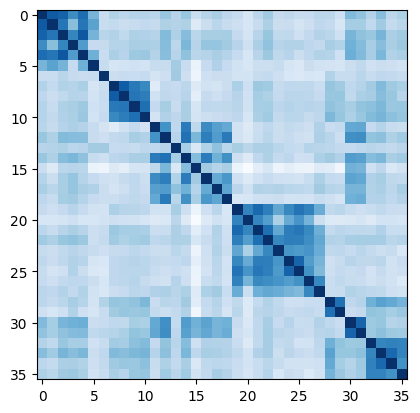

In [28]:
# Draw a heatmap with the summary_similarity_matrix
plt.figure()
# Color scheme blues
plt.imshow(summary_similarity_matrix, cmap = 'Blues')

In [29]:
# Run the community detection algorithm

def get_topics(title_similarity, num_topics = 8, bonus_constant = 0.25, min_size = 3):

  proximity_bonus_arr = np.zeros_like(title_similarity)
  for row in range(proximity_bonus_arr.shape[0]):
    for col in range(proximity_bonus_arr.shape[1]):
      if row == col:
        proximity_bonus_arr[row, col] = 0
      else:
        proximity_bonus_arr[row, col] = 1/(abs(row-col)) * bonus_constant
        
  title_similarity += proximity_bonus_arr

  title_nx_graph = nx.from_numpy_array(title_similarity)

  desired_num_topics = num_topics
  # Store the accepted partitionings
  topics_title_accepted = []

  resolution = 0.85
  resolution_step = 0.01
  iterations = 40

  # Find the resolution that gives the desired number of topics
  topics_title = []
  while len(topics_title) not in [desired_num_topics, desired_num_topics + 1, desired_num_topics + 2]:
    topics_title = community.louvain_communities(title_nx_graph, weight = 'weight', resolution = resolution)
    resolution += resolution_step
  topic_sizes = [len(c) for c in topics_title]
  sizes_sd = np.std(topic_sizes)
  modularity = community.modularity(title_nx_graph, topics_title, weight = 'weight', resolution = resolution)

  lowest_sd_iteration = 0
  # Set lowest sd to inf
  lowest_sd = float('inf')

  for i in range(iterations):
    topics_title = community.louvain_communities(title_nx_graph, weight = 'weight', resolution = resolution)
    modularity = community.modularity(title_nx_graph, topics_title, weight = 'weight', resolution = resolution)
    
    # Check SD
    topic_sizes = [len(c) for c in topics_title]
    sizes_sd = np.std(topic_sizes)
    
    topics_title_accepted.append(topics_title)
    
    if sizes_sd < lowest_sd and min(topic_sizes) >= min_size:
      lowest_sd_iteration = i
      lowest_sd = sizes_sd
      
  # Set the chosen partitioning to be the one with highest modularity
  topics_title = topics_title_accepted[lowest_sd_iteration]
  print(f'Best SD: {lowest_sd}, Best iteration: {lowest_sd_iteration}')
  
  topic_id_means = [sum(e)/len(e) for e in topics_title]
  # Arrange title_topics in order of topic_id_means
  topics_title = [list(c) for _, c in sorted(zip(topic_id_means, topics_title), key = lambda pair: pair[0])]
  # Create an array denoting which topic each chunk belongs to
  chunk_topics = [None] * title_similarity.shape[0]
  for i, c in enumerate(topics_title):
    for j in c:
      chunk_topics[j] = i
            
  return {
    'chunk_topics': chunk_topics,
    'topics': topics_title
    }

In [30]:
# Set num_topics to be 1/4 of the number of chunks, or 8, which ever is smaller
num_topics = 4 #min(int(num_1_chunks / 4), 8)
topics_out = get_topics(summary_similarity_matrix, num_topics = num_topics, bonus_constant = 0.2)
chunk_topics = topics_out['chunk_topics']
topics = topics_out['topics']

Best SD: 1.224744871391589, Best iteration: 0


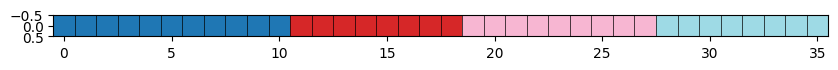

In [31]:
# Plot a heatmap of this array
plt.figure(figsize = (10, 4))
plt.imshow(np.array(chunk_topics).reshape(1, -1), cmap = 'tab20')
# Draw vertical black lines for every 1 of the x-axis 
for i in range(1, len(chunk_topics)):
  plt.axvline(x = i - 0.5, color = 'black', linewidth = 0.5)

In [32]:
def summarize_stage_2(stage_1_outputs, topics, summary_num_words = 250):
  print(f'Stage 2 start time {datetime.now()}')
  
  # Prompt that passes in all the titles of a topic, and asks for an overall title of the topic
  title_prompt_template = """Write an informative title that summarizes each of the following groups of titles. Make sure that the titles capture as much information as possible, 
  and are different from each other:
  {text}
  
  Return your answer in a numbered list, with new line separating each title: 
  1. Title 1
  2. Title 2
  3. Title 3

  TITLES:
  """

  map_prompt_template = """Wite a 75-100 word summary of the following text:
    {text}

    CONCISE SUMMARY:"""

  combine_prompt_template = 'Write a ' + str(summary_num_words) + """-word summary of the following, removing irrelevant information. Finish your answer:
  {text}
  """ + str(summary_num_words) + """-WORD SUMMARY:"""

  title_prompt = PromptTemplate(template=title_prompt_template, input_variables=["text"])
  map_prompt = PromptTemplate(template=map_prompt_template, input_variables=["text"])
  combine_prompt = PromptTemplate(template=combine_prompt_template, input_variables=["text"])

  topics_data = []
  for c in topics:
    topic_data = {
      'summaries': [stage_1_outputs[chunk_id]['summary'] for chunk_id in c],
      'titles': [stage_1_outputs[chunk_id]['title'] for chunk_id in c]
    }
    topic_data['summaries_concat'] = ' '.join(topic_data['summaries'])
    topic_data['titles_concat'] = ', '.join(topic_data['titles'])
    topics_data.append(topic_data)
    
  # Get a list of each community's summaries (concatenated)
  topics_summary_concat = [c['summaries_concat'] for c in topics_data]
  topics_titles_concat = [c['titles_concat'] for c in topics_data]

  # Concat into one long string to do the topic title creation
  topics_titles_concat_all = ''''''
  for i, c in enumerate(topics_titles_concat):
    topics_titles_concat_all += f'''{i+1}. {c}
    '''
  
  # print('topics_titles_concat_all', topics_titles_concat_all)

  title_llm = OpenAI(temperature=0, model_name = 'text-davinci-003')
  title_llm_chain = LLMChain(llm = title_llm, prompt = title_prompt)
  title_llm_chain_input = [{'text': topics_titles_concat_all}]
  title_llm_chain_results = title_llm_chain.apply(title_llm_chain_input)
  
  
  # Split by new line
  titles = title_llm_chain_results[0]['text'].split('\n')
  # Remove any empty titles
  titles = [t for t in titles if t != '']
  # Remove spaces at start or end of each title
  titles = [t.strip() for t in titles]

  map_llm = OpenAI(temperature=0, model_name = 'text-davinci-003')
  reduce_llm = OpenAI(temperature=0, model_name = 'text-davinci-003', max_tokens = -1)

  # Run the map-reduce chain
  docs = [Document(page_content=t) for t in topics_summary_concat]
  chain = load_summarize_chain(chain_type="map_reduce", map_prompt = map_prompt, combine_prompt = combine_prompt, return_intermediate_steps = True,
                              llm = map_llm, reduce_llm = reduce_llm)

  output = chain({"input_documents": docs}, return_only_outputs = True)
  summaries = output['intermediate_steps']
  stage_2_outputs = [{'title': t, 'summary': s} for t, s in zip(titles, summaries)]
  final_summary = output['output_text']

  # Return: stage_1_outputs (title and summary), stage_2_outputs (title and summary), final_summary, chunk_allocations
  out = {
    'stage_2_outputs': stage_2_outputs,
    'final_summary': final_summary
  }
  print(f'Stage 2 done time {datetime.now()}')
  
  return out

In [33]:
# Query GPT-3 to get a summarized title for each topic_data
out = summarize_stage_2(stage_1_outputs, topics, summary_num_words = 250)
stage_2_outputs = out['stage_2_outputs']
stage_2_titles = [e['title'] for e in stage_2_outputs]
stage_2_summaries = [e['summary'] for e in stage_2_outputs]
final_summary = out['final_summary']

Stage 2 start time 2023-10-05 16:18:23.881693
Stage 2 done time 2023-10-05 16:18:38.053068


In [34]:
stage_2_outputs

[{'title': '1. Combatting Gang Violence in Sweden',
  'summary': ' Swedish Prime Minister Ulf Kristersson is meeting with the national army and police chiefs to combat a surge in gang violence, with 11 gun killings in September making it the deadliest month since December 2019. Northvolt, a US-based company, has secured $2 billion in investment from Canadian pension plans and Ontario Municipal Employees Retirement System, and has more than $55 billion worth of contracts with mainly European customers. The government is looking at changing the law to widen the circumstances in which the police can request military help.'},
 {'title': "2. Impact of Senator Menendez's Departure on US-Turkey Relations",
  'summary': " Turkish President Recep Tayyip Erdoğan has suggested that the departure of Senator Robert Menendez (D-NJ) from his position as Senate Foreign Relations Committee chairman could lead to changes in the US-Turkey relationship. Negotiations on Sweden's accession to NATO have been

In [35]:
stage_2_titles

['1. Combatting Gang Violence in Sweden',
 "2. Impact of Senator Menendez's Departure on US-Turkey Relations",
 '3. Nobel Prize Winners in Physics and Chemistry',
 '4. Potential Ownership Changes for SAS Airline and Copenhagen Airport']

In [36]:
final_summary

"\n\nSwedish Prime Minister Ulf Kristersson is meeting with the national army and police chiefs to combat a surge in gang violence. Northvolt, a US-based company, has secured $2 billion in investment from Canadian pension plans and Ontario Municipal Employees Retirement System. The government is looking at changing the law to widen the circumstances in which the police can request military help. Turkish President Recep Tayyip Erdoğan has suggested that the departure of Senator Robert Menendez (D-NJ) from his position as Senate Foreign Relations Committee chairman could lead to changes in the US-Turkey relationship. Moungi Bawendi, Louis Brus, and Alexei Ekimov were awarded the Nobel Prize in Chemistry for their work on quantum dots. Judy Giordan and Rigoberto Advincula developed new chemical methods for producing quantum dots quickly and uniformly. Katalin Karikó and Drew Weissman also won the Nobel Prize in Medicine for discoveries that enabled the creation of mRNA vaccines against CO

In [37]:
def podify(style, titles, summary, topic, lang):
    chat_model = ChatOpenAI(model_name='gpt-3.5-turbo-16k') # Must have set API key as env var
    prompt = f'You are gonna generate a transcript for a podcast covering the following topics {titles}. Here is the content of all topics summarised {summary}. The transcription needs to be in {lang}. The transcrption should be in the style of {style}. Start your response with the following: You are listening to an AI-generated podcast on the theme {topic}, provided to you by PerfectPod AI: Be natural and discuss the themes and topics discussed a way that a podcast would. Dont introduce every topic one by one but connect them in a natural way.'
    text = chat_model.predict(prompt)
    return text

def audiofy(voice, text):  
    audio_voice = voice.split()[0]
    audio = generate(text=text, voice=audio_voice, model="eleven_monolingual_v1", api_key=eleven_api_key)
    save(audio, "news_audio/ADAM.wav")
    return audio

# Save audiofile
def save_audio(audio, num_minutes):
    if not os.path.exists("news_audio"):
        os.makedirs("news_audio")

    # Handling identical file names
    # file_suffix = 0
    # while os.path.exists("news_audio/summary_in_{}_mins_{}.wav".format(num_minutes, file_suffix)):
    #     file_suffix +=1

    save(audio, "news_audio/ADAM.wav")

In [46]:
voice = "Mimi (SWE)"
audio_voice = voice.split()[0]
summary_lang = "English"
if voice.split()[1] == "(SWE)":
    summary_lang = "Swedish"
if voice.split()[1] == "(IT)":
    summary_lang = "Italian"

pod_transcript = podify("Explain this to me like I'm a University student from Sweden", stage_2_titles, final_summary, "Sverige", summary_lang)


In [47]:
pod_transcript

'Du lyssnar på en AI-genererad podcast med temat Sverige, tillhandahållen av PerfectPod AI. Idag kommer vi att diskutera flera intressanta ämnen som påverkar Sverige och omvärlden. Vi börjar med att titta på hur Sveriges premiärminister Ulf Kristersson bekämpar den ökande gängvåldet i landet.\n\nI Sverige har vi sett en oroande ökning av gängrelaterat våld, och premiärminister Kristersson har tagit detta på stort allvar. Han träffar nu nationens armé- och polischef för att diskutera åtgärder mot detta problem. Ett förslag som övervägs är att ändra lagen för att utöka polisens befogenheter att be om militär hjälp. Detta är ett stort steg och kan ha en betydande inverkan på säkerheten i landet.\n\nSamtidigt har vi också intressanta nyheter om USA-Turkiet relationerna. Turkiets president Recep Tayyip Erdoğan har antytt att avgången av Senator Robert Menendez från sin position som ordförande för Senatens utrikesutskott kan leda till förändringar i relationen mellan USA och Turkiet. Detta ä

In [48]:
audio = audiofy(voice, pod_transcript[:102])

def test():
    return audio

RateLimitError: This request exceeds your quota. You have 102 characters remaining, while 2500 characters are required for this request.

In [41]:
demo = gr.Interface(fn=test, 
                    inputs=[ ],
                    outputs= ["audio"]
                    )
demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://e5a521bec9de9f9358.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
